# Performance Evaluation: Sieve of Eratosthenes (MPI)

This notebook automates the performance evaluation described in Chapter 4 (visit /doc/documentation.pdf). It performs the following steps:

1.  **Environment Check**: Verifies the system hardware and MPI version.
2.  **Run Experiments**: Executes the MPI program (`bin/program`) for different problem sizes (`N`) and process counts (`p`).
3.  **Collect Data**: Runs each experiment multiple times (`REPETITIONS`) and calculates the average execution time, parsing the output from the C program.
4.  **Process Data**: Calculates Speedup ($S = T_s / T_p$) and Efficiency ($E = S / p$).
5.  **Generate Outputs**: Displays the final data as a Markdown table (matching Table 4.2) and generates the three required plots for the graphical analysis.

## 1. Imports and Configuration

Here we'll import the necessary libraries and define the experimental parameters.

In [4]:
import subprocess
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---

# Path to your MPI executable
# (Assumes 'sieve' is the MPI version from your Makefile)
PROGRAM_PATH = "./bin/sieve"

# Path to your SEQUENTIAL executable
SEQ_PROGRAM_PATH = "./bin/sieve_seq"

# Problem sizes (N)
N_VALUES = [10**6, 10**7, 10**8]

# Process counts (p)
P_VALUES = [1, 2, 4, 6, 8, 10]

# Number of times to repeat each experiment for a stable average
REPETITIONS = 5

# Set plot style
sns.set_theme(style="whitegrid")

## 2. Experiment Execution

First, we define a helper function to run the C program and parse its output. We'll use a regular expression to find the execution time, as described in your.

**Note**: This cell will take a long time to run, especially for $N = 10^8$.

In [5]:
def run_experiment(p, n):
    """
    Runs the correct program (sequential or parallel) and
    parses its output for execution time.
    """
    
    if p == 1:
        # Run the sequential version
        command = [SEQ_PROGRAM_PATH, str(n)]
    else:
        # Run the parallel MPI version
        command = ["mpirun", "-np", str(p), PROGRAM_PATH, str(n)]
    
    try:
        # Execute the command
        result = subprocess.run(
            command, 
            capture_output=True, 
            text=True, 
            timeout=600  # 10-minute timeout for large runs
        )
        
        if result.returncode != 0:
            print(f"Error running {command}: {result.stderr}")
            return None

        # Parse the output
        # This regex looks for the line from your C code's output
        match = re.search(r"Execution time \(computation only\): (\d+\.\d+) seconds", result.stdout)
        
        if match:
            return float(match.group(1))
        else:
            # Check stderr as well, in case the C program prints to it
            match_err = re.search(r"Execution time \(computation only\): (\d+\.\d+) seconds", result.stderr)
            if match_err:
                return float(match_err.group(1))
            
            print(f"Could not parse time from output: {result.stdout}")
            return None
            
    except Exception as e:
        print(f"An error occurred with {command}: {e}")
        return None

# --- Main Execution Loop ---

results = []
print(f"Starting experiments...")
print(f"Parallel Program: {PROGRAM_PATH}")
print(f"Sequential Program: {SEQ_PROGRAM_PATH}")
print(f"N values: {N_VALUES}")
print(f"p values: {P_VALUES}")
print(f"Repetitions: {REPETITIONS}\n")

# Check that both programs exist before starting
if not os.path.exists(PROGRAM_PATH):
    print(f"ERROR: Parallel program not found at {PROGRAM_PATH}")
    print("Please compile the project first (e.g., 'make all' or 'make')")
elif not os.path.exists(SEQ_PROGRAM_PATH):
    print(f"ERROR: Sequential program not found at {SEQ_PROGRAM_PATH}")
    print("Please compile the project first (e.g., 'make sequential')")
else:
    for n in N_VALUES:
        for p in P_VALUES:
            times = []
            print(f"Running: N={n:<9} p={p:<2}... ", end="")
            
            for i in range(REPETITIONS):
                time = run_experiment(p, n)
                if time is not None:
                    times.append(time)
            
            if times:
                avg_time = np.mean(times)
                print(f"Avg: {avg_time:.4f}s")
                results.append({
                    'N': n,
                    'Processes (p)': p,
                    'Parallel Time (Tp) [s]': avg_time
                })
            else:
                print("Failed.")

print("\nAll experiments complete.")

Starting experiments...
Parallel Program: ./bin/sieve
Sequential Program: ./bin/sieve_seq
N values: [1000000, 10000000, 100000000]
p values: [1, 2, 4, 6, 8, 10]
Repetitions: 5

Running: N=1000000   p=1 ... Avg: 0.0236s
Running: N=1000000   p=2 ... Avg: 0.0301s
Running: N=1000000   p=4 ... Avg: 0.0200s
Running: N=1000000   p=6 ... Avg: 0.0162s
Running: N=1000000   p=8 ... Avg: 0.0115s
Running: N=1000000   p=10... Avg: 0.0095s
Running: N=10000000  p=1 ... Avg: 0.2038s
Running: N=10000000  p=2 ... Avg: 0.2070s
Running: N=10000000  p=4 ... Avg: 0.1362s
Running: N=10000000  p=6 ... Avg: 0.1125s
Running: N=10000000  p=8 ... Avg: 0.0963s
Running: N=10000000  p=10... Avg: 0.0885s
Running: N=100000000 p=1 ... Avg: 2.3516s
Running: N=100000000 p=2 ... Avg: 1.9213s
Running: N=100000000 p=4 ... Avg: 1.3413s
Running: N=100000000 p=6 ... Avg: 1.1929s
Running: N=100000000 p=8 ... Avg: 1.1080s
Running: N=100000000 p=10... Avg: 1.0597s

All experiments complete.


## 4. Data Processing and Table Generation

Now, we'll process the raw timing data into a `pandas` DataFrame to calculate Speedup and Efficiency. The sequential time ($T_s$) is the time measured for $p=1$.

In [10]:
# Check if any results were actually collected
if not results:
    print("ERROR: The 'results' list is empty.")
    print("Please check the 'Experiment Execution' cell for errors.")
    print("Common causes: Program path is wrong, compile failed, or output parsing failed.")
else:
    # Convert results list to a DataFrame
    df = pd.DataFrame(results)

    # Extract Sequential Time (Ts) for each N (which is the Tp where p=1)
    df_ts = df[df['Processes (p)'] == 1][['N', 'Parallel Time (Tp) [s]']]
    
    # --- THIS IS THE FIX ---
    # Rename the column to 'Sequential Time (Ts) [s]'
    df_ts = df_ts.rename(columns={'Parallel Time (Tp) [s]': 'Sequential Time (Ts) [s]'})

    # Merge Ts back into the main DataFrame
    df = pd.merge(df, df_ts, on='N')

    # Calculate Speedup and Efficiency
    df['Speedup (S)'] = df['Sequential Time (Ts) [s]'] / df['Parallel Time (Tp) [s]']
    df['Efficiency (E)'] = df['Speedup (S)'] / df['Processes (p)']

    # Reorder columns to match your LaTeX table
    df = df[[
        'N', 
        'Processes (p)',
        'Sequential Time (Ts) [s]', 
        'Parallel Time (Tp) [s]', 
        'Speedup (S)', 
        'Efficiency (E)'
    ]]

    print("--- Execution Results Table ---")
    
    # Display the final, correct DataFrame
    display(df)

--- Execution Results Table ---


,N,Processes (p),Sequential Time (Ts) [s],Parallel Time (Tp) [s],Speedup (S),Efficiency (E)
0,1000000,1,0.0236,0.023600,1.000000,1.000000
1,1000000,2,0.0236,0.030059,0.785128,0.392564
2,1000000,4,0.0236,0.019974,1.181548,0.295387
3,1000000,6,0.0236,0.016223,1.454725,0.242454
4,1000000,8,0.0236,0.011470,2.057613,0.257202
5,1000000,10,0.0236,0.009544,2.472758,0.247276
6,10000000,1,0.2038,0.203800,1.000000,1.000000
7,10000000,2,0.2038,0.206983,0.984624,0.492312
8,10000000,4,0.2038,0.136218,1.496136,0.374034
9,10000000,6,0.2038,0.112499,1.811575,0.301929


## 5. Graphical Analysis

Here we generate the plots for your report.

### Figure 1: Comparison of Execution Times

*(Corresponds to your `fig:time_comparison`)*

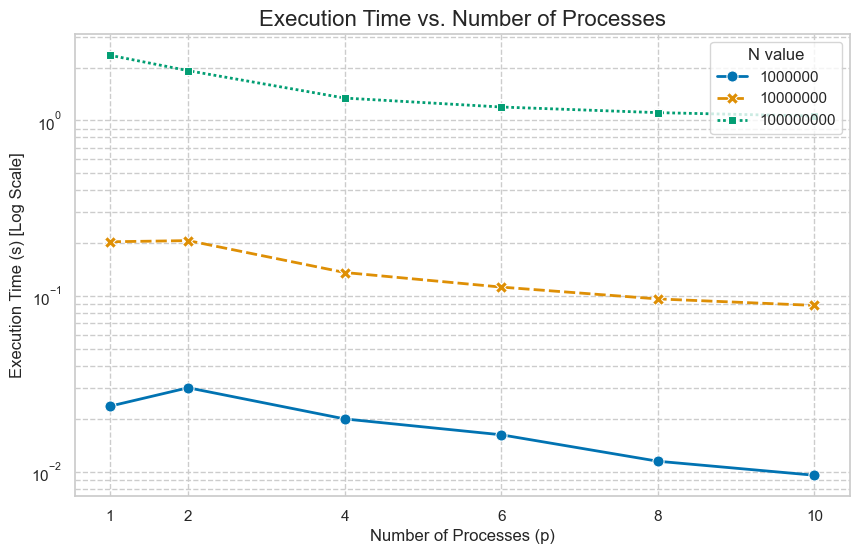

In [16]:
plt.figure(figsize=(10, 6))
g = sns.lineplot(
    data=df, 
    x='Processes (p)', 
    y='Parallel Time (Tp) [s]', 
    hue='N', 
    style='N', 
    markers=True, 
    markersize=8, 
    linewidth=2,
    # palette="deep"  # <-- Add this line
    # Other good options:
    palette="colorblind"
    # palette="viridis"
)

# Use a log scale for time, as the values vary greatly
g.set_yscale('log')
g.set_title('Execution Time vs. Number of Processes', fontsize=16)
g.set_xlabel('Number of Processes (p)', fontsize=12)
g.set_ylabel('Execution Time (s) [Log Scale]', fontsize=12)
plt.legend(title='N value')
plt.xticks(P_VALUES) # Ensure all p values are shown as ticks
plt.grid(True, which="both", ls="--")

# Save the figure
# plt.savefig('figures/time_comparison.png')
plt.show()

### Figure 2: Speedup Analysis

*(Corresponds to your `fig:speedup`)*

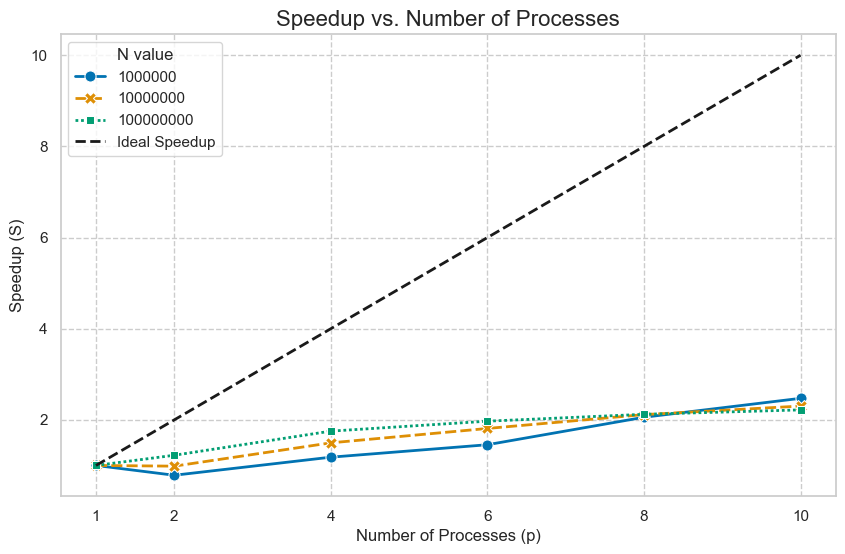

In [19]:
plt.figure(figsize=(10, 6))
g = sns.lineplot(
    data=df, 
    x='Processes (p)', 
    y='Speedup (S)', 
    hue='N', 
    style='N', 
    markers=True, 
    markersize=8, 
    linewidth=2,
    palette="colorblind"
)

# Plot the ideal speedup line (y=x)
ideal_x = [min(P_VALUES), max(P_VALUES)]
ideal_y = ideal_x
plt.plot(ideal_x, ideal_y, 'k--', linewidth=2, label='Ideal Speedup')

g.set_title('Speedup vs. Number of Processes', fontsize=16)
g.set_xlabel('Number of Processes (p)', fontsize=12)
g.set_ylabel('Speedup (S)', fontsize=12)
plt.legend(title='N value')
plt.xticks(P_VALUES)
plt.grid(True, which="both", ls="--")

# Save the figure
# plt.savefig('figures/speedup.png')
plt.show()

### Figure 3: Efficiency Analysis

*(Corresponds to your `fig:efficiency`)*

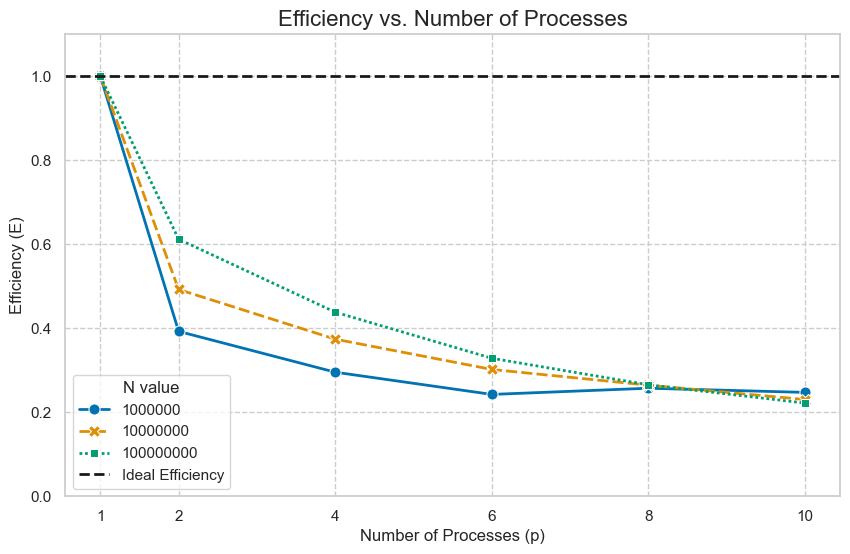

In [20]:
plt.figure(figsize=(10, 6))
g = sns.lineplot(
    data=df, 
    x='Processes (p)', 
    y='Efficiency (E)', 
    hue='N', 
    style='N', 
    markers=True, 
    markersize=8, 
    linewidth=2,
    palette="colorblind"
)

# Plot the ideal efficiency line (y=1)
plt.axhline(1.0, color='k', linestyle='--', linewidth=2, label='Ideal Efficiency')

g.set_title('Efficiency vs. Number of Processes', fontsize=16)
g.set_xlabel('Number of Processes (p)', fontsize=12)
g.set_ylabel('Efficiency (E)', fontsize=12)
g.set_ylim(0, 1.1) # Efficiency is between 0 and 1
plt.legend(title='N value', loc='lower left')
plt.xticks(P_VALUES)
plt.grid(True, which="both", ls="--")

# Save the figure
# plt.savefig('figures/efficiency.png')
plt.show()